# Introduction

# Preparatory analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [136]:
data = pd.read_csv('data/diabetic_data.csv')

In [137]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [138]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [139]:
data.shape

(101766, 50)

In [140]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [141]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [142]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [143]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [144]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [145]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [146]:
#FARLO DOPO ANALISI ESPLORATIVA, ALTRIMENTI ALCUNE OSSERVAZIONI UTILI SI PERDONO

#labels = (data['diag_1'] == '?') | (data['diag_2'] == '?') | (data['diag_3'] == '?')
#data.drop(data[labels].index, inplace=True) # data[~labels] OP

In [147]:
data.shape

(101766, 45)

In [148]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

# Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [149]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Changing unique values for some columns

Is this safe for logistic regression?

In [150]:
data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
data.replace('No', 0, inplace=True)
data.replace('Ch', 1, inplace=True)
data.replace('Yes', 1, inplace=True)
data.replace(['Steady', 'Up', 'Down'], [1, 2, 3], inplace=True) #non ottimale

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_4340\3821934187.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(['NO', '>30', '<30'], [0, 1, 2], inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_4340\3821934187.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('No', 0, inplace=True)
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_4340\3821934187.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitl

In [151]:
data['age'].unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [152]:
dict = {'[0-10)':0, '[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6, '[70-80)':7, '[80-90)':8, '[90-100)':9}
data.replace(dict, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_4340\3077306244.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(dict, inplace=True)


In [153]:
data

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0,6,25,1,1,41,...,0,0,0,0,0,0,0,0,0,0
1,149190,55629189,Caucasian,Female,1,1,1,7,3,59,...,0,2,0,0,0,0,0,1,1,1
2,64410,86047875,AfricanAmerican,Female,2,1,1,7,2,11,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,Caucasian,Male,3,1,1,7,2,44,...,0,2,0,0,0,0,0,1,1,0
4,16680,42519267,Caucasian,Male,4,1,1,7,1,51,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,7,1,3,7,3,51,...,0,3,0,0,0,0,0,1,1,1
101762,443847782,74694222,AfricanAmerican,Female,8,1,4,5,5,33,...,0,1,0,0,0,0,0,0,1,0
101763,443854148,41088789,Caucasian,Male,7,1,1,7,1,53,...,0,3,0,0,0,0,0,1,1,0
101764,443857166,31693671,Caucasian,Female,8,2,3,7,10,45,...,0,2,0,0,0,0,0,1,1,0


# Exploratory data analysis

## What is the most frequent readmission type?

In [154]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
0    0.539119
1    0.349282
2    0.111599
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

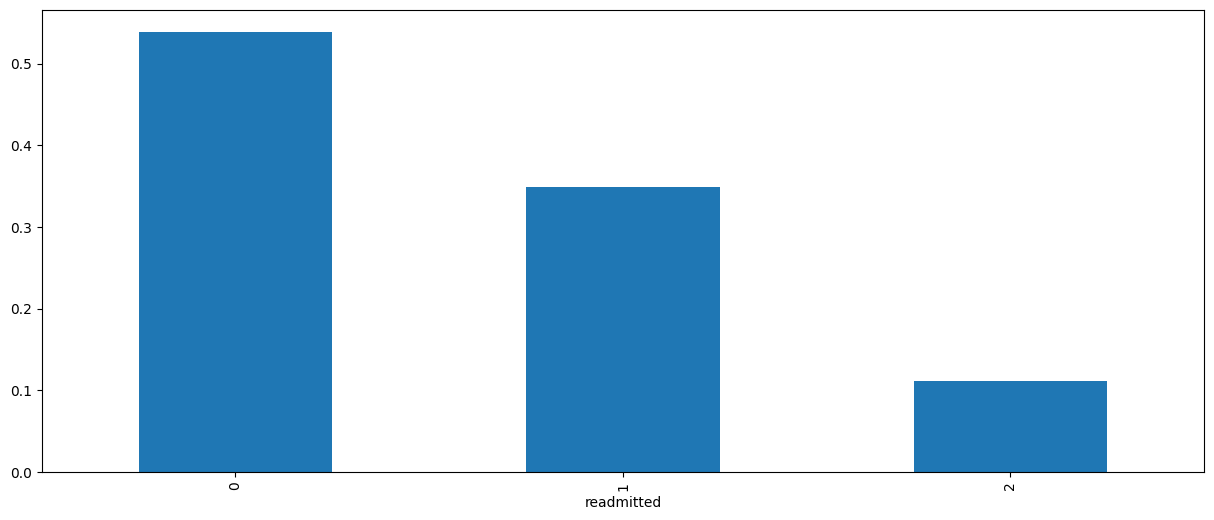

In [155]:
freqs.plot.bar(figsize=(15, 6))

Il 54% dei pazienti non è tornato in ospedale, il 35% è tornato in ospedale in un periodo che supera i 30 giorni e, infine, il restante 11% è tornato entro i 30 giorni. Da questo si evince che le valutazioni effettuate dai medici su #num pazienti si sono rivelate corrette e senza falle. ??

In [156]:
#data['readmitted'].plot.bar()

## What is the distribution of gender between readmissions?

## Distribution of gender

In [157]:
data['gender'].unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [158]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

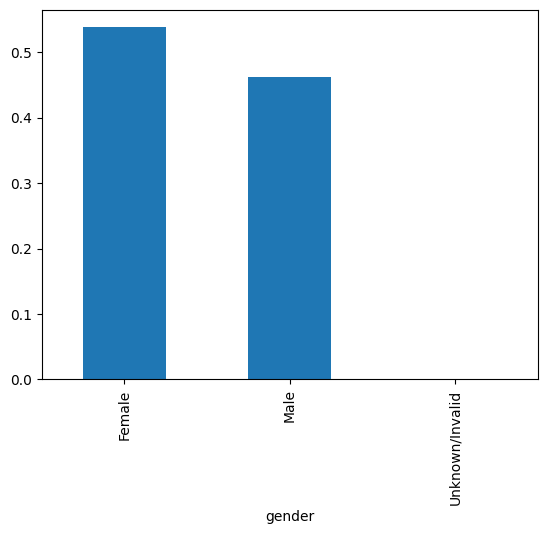

In [159]:
freqs.plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [160]:
data['gender'].value_counts().sort_index()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

## Distribution of gender between readmissions

In [161]:
d = data[['gender', 'readmitted']]

freqs = (d.groupby('gender').value_counts(normalize=True))
print(freqs)

gender           readmitted
Female           0             0.530782
                 1             0.356767
                 2             0.112452
Male             0             0.548783
                 1             0.340601
                 2             0.110615
Unknown/Invalid  0             1.000000
Name: proportion, dtype: float64


<Axes: xlabel='gender,readmitted'>

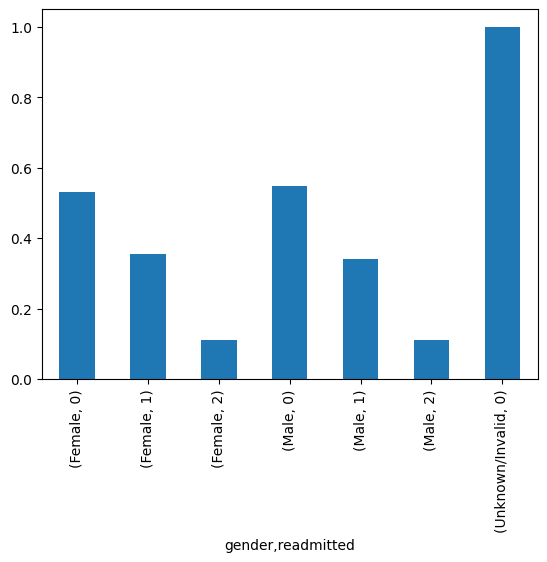

In [162]:
freqs.plot.bar()

....

# Inferential Analysis

## What is the average time in hospital?

In [163]:
mean = data['time_in_hospital'].mean()
print(mean)

4.395986871843248


From the results above, we find that the average time in hospital is 4 days. Is this due to chance or is it statistically significant? Let's run a statistical test and find out.

In [164]:
t, p = stats.ttest_1samp(data['time_in_hospital'], mean)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.0 
Alpha:  0.05


The p value is greater than the significance level, so we cannot reject the null hypothesis. <br>
This means that data do not provide enough evidence to say that the true time in hospital differs from 4 and an half day.

<Axes: >

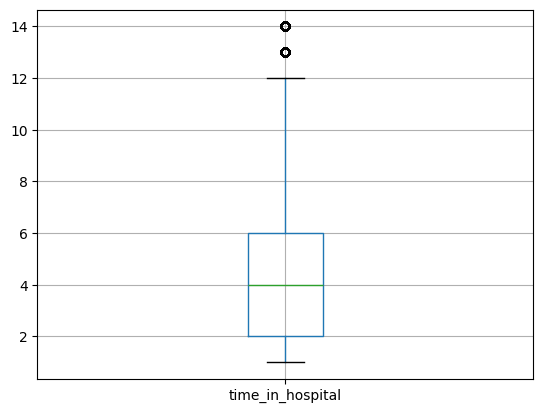

In [165]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

In [166]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254429133858268


In [167]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Again, is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [168]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.023396538894888e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 
Let's study the relationship between time_in_hospital and readmitted, using logistic regression.

Let's use a boxplot to study the distribution of time_in_hospital between readmissions.

<Axes: title={'center': 'time_in_hospital'}, xlabel='readmitted'>

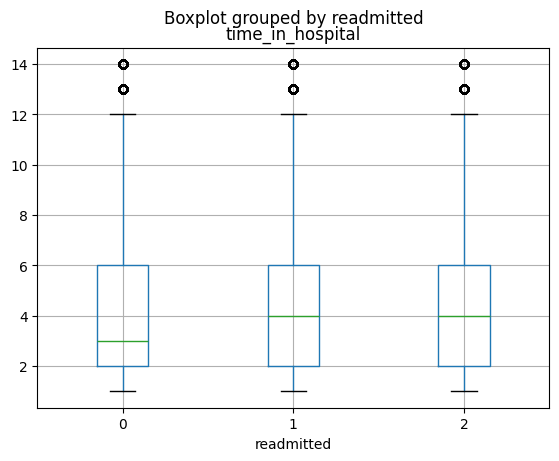

In [169]:
data.boxplot(by='readmitted', column='time_in_hospital')

For classes 1 and 2, the bloxplots are indentical. For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical.

In [170]:
## Altro?

## Logistic regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. To do thiis, let's first study if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [171]:
from statsmodels.formula.api import logit, mnlogit

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know that a patient has been readmitted or not.

In [172]:
view = data.replace({'readmitted': 2}, 1)

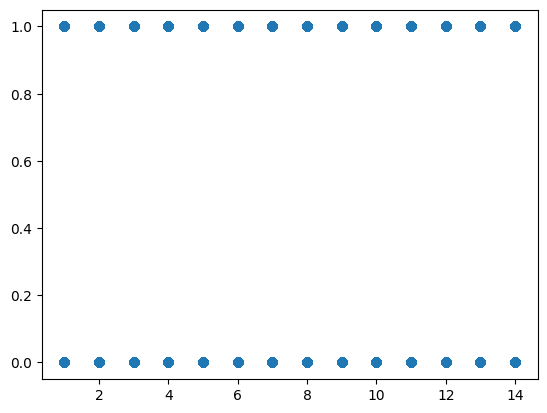

In [173]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [174]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688770
         Iterations 4


In [175]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                          Logit   Df Residuals:                   101764
Method:                           MLE   Df Model:                            1
Date:                Wed, 26 Feb 2025   Pseudo R-squ.:                0.001903
Time:                        20:27:46   Log-Likelihood:                -70093.
converged:                       True   LL-Null:                       -70227.
Covariance Type:            nonrobust   LLR p-value:                 4.311e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3085      0.011    -27.469      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.334      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [176]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [177]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

In [178]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943557
         Iterations 6


In [179]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                        MNLogit   Df Residuals:                   101762
Method:                           MLE   Df Model:                            2
Date:                Wed, 26 Feb 2025   Pseudo R-squ.:                0.001737
Time:                        20:27:51   Log-Likelihood:                -96022.
converged:                       True   LL-Null:                       -96189.
Covariance Type:            nonrobust   LLR p-value:                 2.868e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.597      0.000      -0.578      -0.530
time_in_hospital     0.0274      0.002     11.967      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8254      0.019    -98.345      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.819      0.000       0.049       0.062
====================================================================================
"""

In [180]:
np.exp(0.0556)

np.float64(1.0571747292596514)

## Complete logit regressor

Let's define a function that build the formula automatically

In [195]:
def buildFormula(columns):
    formula = 'readmitted ~ ' + columns[0]
    
    for s in columns[1:-1]:
        formula = formula + ' + ' + s
        
    return formula

In [182]:
view = data.replace({'readmitted': 2}, 1)

In [183]:
view = view.drop(columns=['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'])

Variables "citoglipton" and "examide" has identical values for each observations. They are correlated, so we need to remove them in order to build a regression model.

In [184]:
data['citoglipton'].unique()

array([0])

In [185]:
data['examide'].unique()

array([0])

In [186]:
formula = 'readmitted ~ age'
for s in view.columns[1:-1]:
    formula = formula + ' + ' + s

In [187]:
formula

'readmitted ~ age + time_in_hospital + num_lab_procedures + num_procedures + num_medications + number_outpatient + number_emergency + number_inpatient + number_diagnoses + metformin + repaglinide + nateglinide + chlorpropamide + glimepiride + acetohexamide + glipizide + glyburide + tolbutamide + pioglitazone + rosiglitazone + acarbose + miglitol + troglitazone + tolazamide + insulin + glyburide_metformin + glipizide_metformin + glimepiride_pioglitazone + metformin_rosiglitazone + metformin_pioglitazone + change + diabetesMed'

In [188]:
model = logit(formula, view).fit()

         Current function value: 0.653063
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [189]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                          Logit   Df Residuals:                   101733
Method:                           MLE   Df Model:                           32
Date:                Wed, 26 Feb 2025   Pseudo R-squ.:                 0.05365
Time:                        20:28:16   Log-Likelihood:                -66460.
converged:                      False   LL-Null:                       -70227.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4323      0.038    -38.157      0.000      -1.506      -1.359
age                          0.0249      0.004      5.710      0.000       0.016       0.033
time_in_hospital             0.0111      0.003      4.341      0.000       0.006       0.016
num_lab_procedures           0.0014      0.000      3.900      0.000       0.001       0.002
num_procedures              -0.0465      0.004    -10.973      0.000      -0.055      -0.038
num_medications              0.0006      0.001      0.627      0.530      -0.001       0.003
number_outpatient            0.0841      0.006     13.995      0.000       0.072       0.096
number_emergency             0.2211      0.012     17.957      0.000       0.197       0.245
number_inpatient             0.3696      0.007     53.315      0.000       0.356       0.383
number_diagnoses             0.0777      0.004     20.936      0.000       0.070       0.085
metformin                   -0.0821      0.016     -5.111      0.000      -0.114      -0.051
repaglinide                  0.1190      0.045      2.652      0.008       0.031       0.207
nateglinide                  0.0404      0.071      0.571      0.568      -0.098       0.179
chlorpropamide               0.1928      0.193      0.998      0.318      -0.186       0.571
glimepiride                  0.0120      0.025      0.471      0.638      -0.038       0.062
acetohexamide               20.7000   2.76e+04      0.001      0.999   -5.41e+04    5.41e+04
glipizide                    0.0933      0.018      5.202      0.000       0.058       0.129
glyburide                    0.0287      0.019      1.536      0.125      -0.008       0.065
tolbutamide                 -0.4059      0.443     -0.916      0.360      -1.275       0.463
pioglitazone                 0.0796      0.024      3.314      0.001       0.033       0.127
rosiglitazone                0.0798      0.026      3.096      0.002       0.029       0.130
acarbose                     0.3970      0.113      3.498      0.000       0.175       0.619
miglitol                     0.5424      0.287      1.889      0.059      -0.020       1.105
troglitazone                 0.8826      1.225      0.720      0.471      -1.519       3.284
tolazamide                  -0.2082      0.327     -0.636      0.525      -0.849       0.433
insulin                      0.0392      0.011      3.558      0.000       0.018       0.061
glyburide_metformin          0.0525      0.074      0.705      0.481      -0.093       0.198
glipizide_metformin          0.6500      0.580      1.122      0.262      -0.486       1.786
glimepiride_pioglitazone    19.5325   1.81e+04      0.001      0.999   -3.54e+04    3.54e+04
metformin_rosiglitazone    -18.3636   7361.525     -0.002      0.998   -1.44e+04    1.44e+04
metformin_pioglitazone     -17.9578   1.21e+04     -0.001      0.999   -2.38e+04    2.38e+04
change                      -0.0217      0.023     -0.934      0.350      -0.06

## Backward selection

# NUOVE VARIABILI DA ELIMINARE

In [ ]:
view = view.drop(columns=['num_medications', 'nateglinide', 'glimepiride', 'chlorpropamide', 'acetohexamide', 'glyburide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'insulin','change'])

In [191]:
view.columns[0:-1]


Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'diabetesMed'],
      dtype='object')

In [196]:
formula = buildFormula(view.columns)

In [197]:
formula

'readmitted ~ age + time_in_hospital + num_lab_procedures + num_procedures + number_outpatient + number_emergency + number_inpatient + number_diagnoses + metformin + repaglinide + glimepiride + glipizide + pioglitazone + rosiglitazone + acarbose + glyburide_metformin + glipizide_metformin + glimepiride_pioglitazone + metformin_rosiglitazone + metformin_pioglitazone + diabetesMed'

In [198]:
view['readmitted'].unique()

array([0, 1])

In [199]:
model = logit(formula, view).fit()

         Current function value: 0.653200
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [200]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101766
Model:                          Logit   Df Residuals:                   101744
Method:                           MLE   Df Model:                           21
Date:                Wed, 26 Feb 2025   Pseudo R-squ.:                 0.05345
Time:                        20:29:52   Log-Likelihood:                -66474.
converged:                      False   LL-Null:                       -70227.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4377      0.037    -38.415      0.000      -1.511      -1.364
age                          0.0234      0.004      5.419      0.000       0.015       0.032
time_in_hospital             0.0127      0.002      5.286      0.000       0.008       0.017
num_lab_procedures           0.0015      0.000      4.308      0.000       0.001       0.002
num_procedures              -0.0455      0.004    -11.557      0.000      -0.053      -0.038
number_outpatient            0.0842      0.006     14.027      0.000       0.072       0.096
number_emergency             0.2223      0.012     18.059      0.000       0.198       0.246
number_inpatient             0.3704      0.007     53.512      0.000       0.357       0.384
number_diagnoses             0.0791      0.004     21.646      0.000       0.072       0.086
metformin                   -0.0963      0.014     -6.738      0.000      -0.124      -0.068
repaglinide                  0.1087      0.044      2.445      0.014       0.022       0.196
glimepiride                 -0.0038      0.024     -0.158      0.875      -0.052       0.044
glipizide                    0.0731      0.016      4.553      0.000       0.042       0.105
pioglitazone                 0.0671      0.023      2.931      0.003       0.022       0.112
rosiglitazone                0.0672      0.025      2.714      0.007       0.019       0.116
acarbose                     0.3876      0.113      3.424      0.001       0.166       0.610
glyburide_metformin          0.0365      0.074      0.494      0.622      -0.108       0.182
glipizide_metformin          0.6361      0.578      1.100      0.271      -0.498       1.770
glimepiride_pioglitazone    19.4629   1.77e+04      0.001      0.999   -3.47e+04    3.47e+04
metformin_rosiglitazone    -16.3443   2699.240     -0.006      0.995   -5306.757    5274.069
metformin_pioglitazone     -17.9019    1.2e+04     -0.001      0.999   -2.35e+04    2.35e+04
diabetesMed                  0.2562      0.017     15.166      0.000       0.223       0.289
============================================================================================
"""

In [115]:
view = view.drop(columns=['glimepiride', 'glyburide_metformin'])

In [116]:
view.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'metformin', 'repaglinide', 'glipizide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'readmitted'],
      dtype='object')

In [117]:
formula = 'readmitted ~ age'
for s in view.columns[1:-1]:
    formula = formula + ' + ' + s

In [118]:
model = logit(formula, view).fit()

PatsyError: Error evaluating factor: NameError: name 'glimepiride' is not defined
    readmitted ~ age + time_in_hospital + num_lab_procedures + num_procedures + number_outpatient + number_emergency + number_inpatient + number_diagnoses + metformin + repaglinide + glipizide + pioglitazone + rosiglitazone + acarbose + glipizide-metformin + glimepiride-pioglitazone + metformin-rosiglitazone + metformin-pioglitazone + diabetesMed
                                                                                                                                                                                                                                                                   ^^^^^^^^^^^

# Predictive Analysis

## PCA + logistic regression
## LDA
## Naive Bayes

# Conclusions